# Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Пункт - 1 - Обучение модели (1 балл)

## Решение
В этом блоке необходимо написать код. Можно создать столько ячеек с кодом, сколько нужно для выполнения задания

Шаблон кода по настройке валидации и оценке качества:
```
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12341234)

cv_predictions = []
cv_target = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X=df, y=df['Survived'])):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    y_train = train['Survived']
    y_val = val['Survived']

    x_train = train.drop('Survived', axis=1)
    x_val = val.drop('Survived', axis=1)

    model = LogisticRegression()

    model.fit(X=x_train, y=y_train)
    pred_train = model.predict_proba(x_train)[:, 1]
    pred_val = model.predict_proba(x_val)[:, 1]
    cv_predictions.append((pred_train, pred_val))

    cv_target.append((y_train, y_val))

pred_train = np.hstack([i[0] for i in cv_predictions])
pred_val = np.hstack([i[1] for i in cv_predictions])

cv_target_train = np.hstack([i[0] for i in cv_target])
cv_target_val = np.hstack([i[1] for i in cv_target])

model_quality = roc_auc_score(y_true=cv_target_val, y_pred=pred_val)
```

## Загружаем данные

In [4]:
df = pd.read_csv('resources/train.csv')
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропуски в данных:\n{df.isnull().sum()}")

Размер датасета: (891, 12)
Колонки: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Типы данных:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Пропуски в данных:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Базовый анализ данных

In [5]:
print("Статистика по целевой переменной Survived:")
print(df['Survived'].value_counts())
print(f"Доля выживших: {df['Survived'].mean():.3f}")

print("\nВыживаемость по классам:")
print(df.groupby('Pclass')['Survived'].agg(['mean', 'count']))

print("\nВыживаемость по полу:")
print(df.groupby('Sex')['Survived'].agg(['mean', 'count']))

print("\nВыживаемость по порту посадки:")
print(df.groupby('Embarked')['Survived'].agg(['mean', 'count']))

Статистика по целевой переменной Survived:
Survived
0    549
1    342
Name: count, dtype: int64
Доля выживших: 0.384

Выживаемость по классам:
            mean  count
Pclass                 
1       0.629630    216
2       0.472826    184
3       0.242363    491

Выживаемость по полу:
            mean  count
Sex                    
female  0.742038    314
male    0.188908    577

Выживаемость по порту посадки:
              mean  count
Embarked                 
C         0.553571    168
Q         0.389610     77
S         0.336957    644


### Визуализация зависимостей

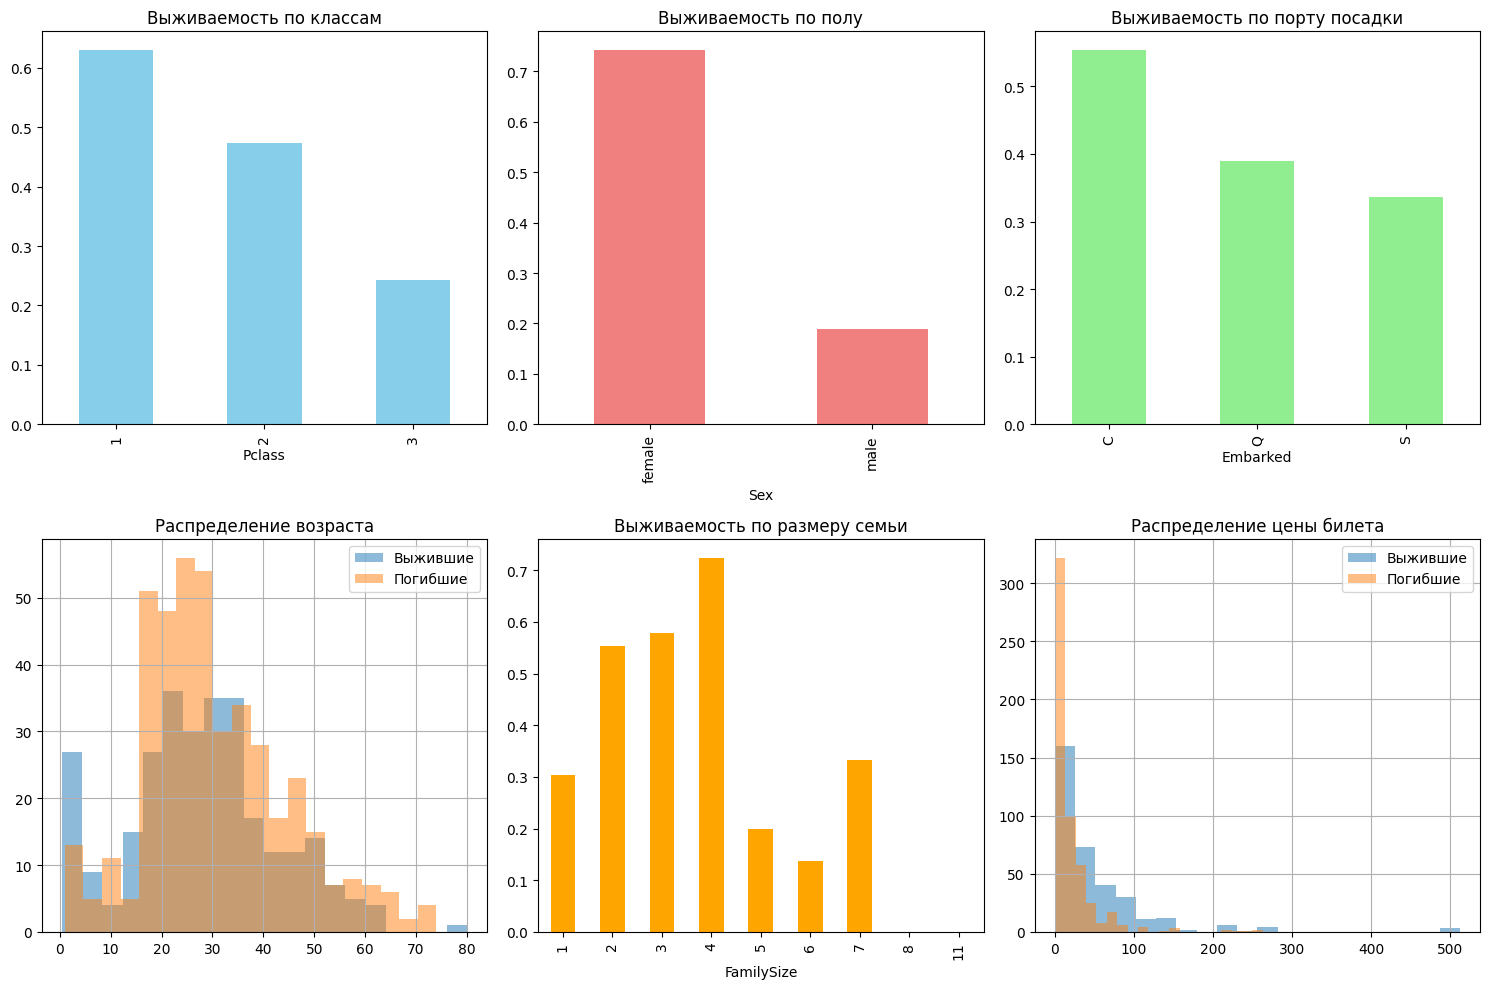

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Выживаемость по классам
df.groupby('Pclass')['Survived'].mean().plot(kind='bar', ax=axes[0,0], title='Выживаемость по классам', color='skyblue')

# Выживаемость по полу
df.groupby('Sex')['Survived'].mean().plot(kind='bar', ax=axes[0,1], title='Выживаемость по полу', color='lightcoral')

# Выживаемость по порту посадки
df.groupby('Embarked')['Survived'].mean().plot(kind='bar', ax=axes[0,2], title='Выживаемость по порту посадки', color='lightgreen')

# Распределение возраста для выживших и погибших
df[df['Survived']==1]['Age'].hist(alpha=0.5, label='Выжившие', ax=axes[1,0], bins=20)
df[df['Survived']==0]['Age'].hist(alpha=0.5, label='Погибшие', ax=axes[1,0], bins=20)
axes[1,0].set_title('Распределение возраста')
axes[1,0].legend()

# Влияние размера семьи
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.groupby('FamilySize')['Survived'].mean().plot(kind='bar', ax=axes[1,1], title='Выживаемость по размеру семьи', color='orange')

# Цена билета для выживших и погибших
df[df['Survived']==1]['Fare'].hist(alpha=0.5, label='Выжившие', ax=axes[1,2], bins=20)
df[df['Survived']==0]['Fare'].hist(alpha=0.5, label='Погибшие', ax=axes[1,2], bins=20)
axes[1,2].set_title('Распределение цены билета')
axes[1,2].legend()

plt.tight_layout()
plt.show()

## Подготовка данных для моделирования

In [8]:
df_model = df.copy()

# Создаем дополнительные признаки
df_model['FamilySize'] = df_model['SibSp'] + df_model['Parch'] + 1
df_model['IsAlone'] = (df_model['FamilySize'] == 1).astype(int)
df_model['Title'] = df_model['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Группируем редкие титулы
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss', 
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Countess': 'Rare',
    'Ms': 'Miss',
    'Lady': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Mme': 'Mrs',
    'Capt': 'Rare',
    'Sir': 'Rare'
}
df_model['Title'] = df_model['Title'].map(title_mapping)

print("Распределение титулов:")
print(df_model['Title'].value_counts())

print("\nВыживаемость по титулам:")
print(df_model.groupby('Title')['Survived'].agg(['mean', 'count']))

Распределение титулов:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

Выживаемость по титулам:
            mean  count
Title                  
Master  0.575000     40
Miss    0.702703    185
Mr      0.156673    517
Mrs     0.793651    126
Rare    0.347826     23


## Отбираем признаки для модели

In [ ]:
# Не используем следующие признаки:
# Name - слишком много уникальных значений, используем только для извлечения Title
# Ticket - слишком много уникальных значений, сложно стандартизировать
# Cabin - слишком много пропусков (~77%), даже если использовать первую букву
# PassengerId - просто идентификатор, не влияет на выживаемость
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Создаем матрицу признаков
X = df_model[features].copy()
y = df_model['Survived'].copy()

# Создаем только один дополнительный признак - размер семьи
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1

# Кодируем категориальные признаки
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

print(f"Размерность данных после кодирования: {X.shape}")
print(f"Признаки: {X.columns.tolist()}")

Размерность данных после кодирования: (891, 9)
Признаки: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Sex_male', 'Embarked_Q', 'Embarked_S']


## Настройка валидации и обучение модели

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12341234)

# Создаем пайплайн для обработки данных
cv_predictions = []
cv_target = []

for idx, (train_idx, val_idx) in enumerate(cv.split(X=X, y=y)):
    # Разделяем данные
    x_train = X.iloc[train_idx].copy()
    x_val = X.iloc[val_idx].copy()
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]
    
    # Обрабатываем пропуски в возрасте
    age_imputer = SimpleImputer(strategy='median')
    x_train['Age'] = age_imputer.fit_transform(x_train[['Age']])
    x_val['Age'] = age_imputer.transform(x_val[['Age']])
    
    # Масштабируем признаки
    scaler = StandardScaler()
    numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
    x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
    x_val[numeric_cols] = scaler.transform(x_val[numeric_cols])
    
    # Обучаем модель
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X=x_train, y=y_train)
    
    # Предсказываем
    pred_train = model.predict_proba(x_train)[:, 1]
    pred_val = model.predict_proba(x_val)[:, 1]
    cv_predictions.append((pred_train, pred_val))
    cv_target.append((y_train, y_val))
    
    print(f"Fold {idx+1} - Коэффициенты модели:")
    coef_df = pd.DataFrame({
        'feature': x_train.columns,
        'coef': model.coef_[0]
    }).sort_values('coef', ascending=False)
    print(coef_df.head(10))
    print(f"ROC-AUC на валидации: {roc_auc_score(y_val, pred_val):.4f}\n")

# Объединяем предсказания
pred_train = np.hstack([i[0] for i in cv_predictions])
pred_val = np.hstack([i[1] for i in cv_predictions])
cv_target_train = np.hstack([i[0] for i in cv_target])
cv_target_val = np.hstack([i[1] for i in cv_target])

# Оценка качества
model_quality = roc_auc_score(y_true=cv_target_val, y_score=pred_val)
print(f"\nИтоговый ROC-AUC на валидации: {model_quality:.4f}")

Fold 1 - Коэффициенты модели:
      feature      coef
4        Fare  0.184267
3       Parch -0.020374
7  Embarked_Q -0.117665
5  FamilySize -0.189195
2       SibSp -0.265112
8  Embarked_S -0.302874
1         Age -0.537399
0      Pclass -0.953758
6    Sex_male -2.477045
ROC-AUC на валидации: 0.8929

Fold 2 - Коэффициенты модели:
      feature      coef
7  Embarked_Q  0.134658
4        Fare  0.039192
3       Parch  0.007004
5  FamilySize -0.143858
2       SibSp -0.212865
1         Age -0.460778
8  Embarked_S -0.562325
0      Pclass -1.099052
6    Sex_male -2.644072
ROC-AUC на валидации: 0.8222

Fold 3 - Коэффициенты модели:
      feature      coef
4        Fare  0.013226
3       Parch -0.008645
7  Embarked_Q -0.035434
5  FamilySize -0.168346
2       SibSp -0.240704
8  Embarked_S -0.371965
1         Age -0.513523
0      Pclass -1.134731
6    Sex_male -2.671258
ROC-AUC на валидации: 0.8485

Fold 4 - Коэффициенты модели:
      feature      coef
4        Fare  0.131270
3       Parch  0.04934

## Ответ
В этом блоке необходимо вывести ответ для этой части задания. Ответ должен описаться на написанный код, построенные визуализации и проведенные расчеты. Если необходимо, то можно записать ответ в нескольких ячейках.

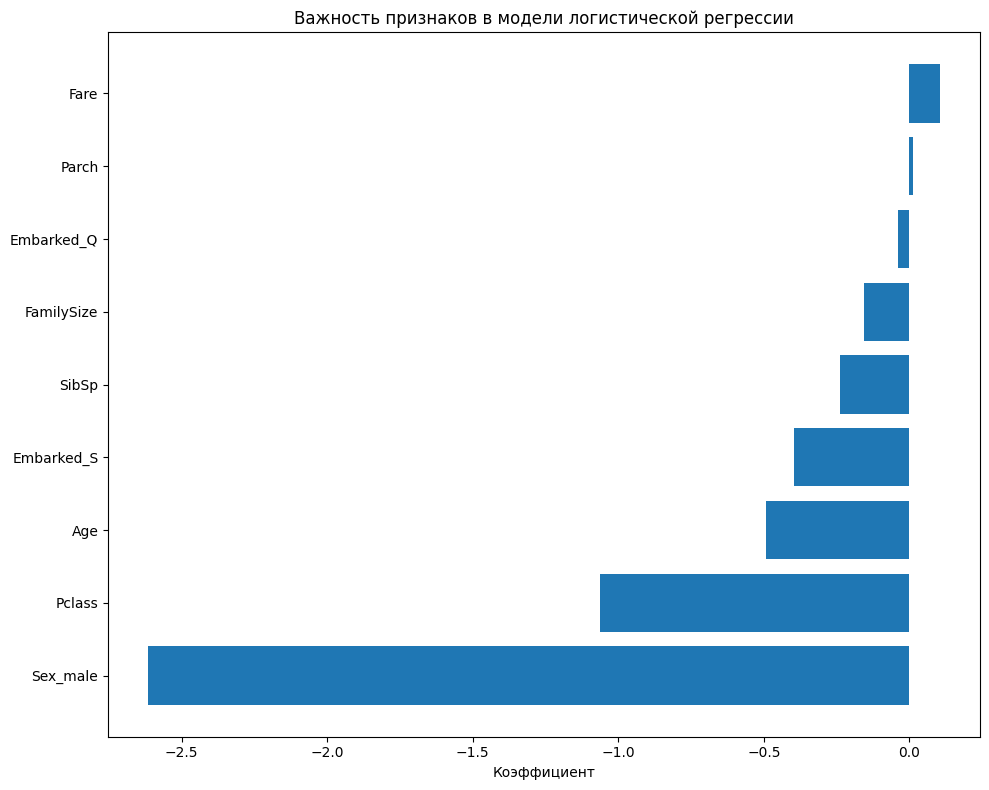

Топ-5 наиболее важных признаков:
      feature  coefficient
4        Fare     0.106583
3       Parch     0.013957
7  Embarked_Q    -0.039787
5  FamilySize    -0.156093
2       SibSp    -0.238586

Топ-5 наименее важных признаков:
      feature  coefficient
2       SibSp    -0.238586
8  Embarked_S    -0.397348
1         Age    -0.493930
0      Pclass    -1.064025
6    Sex_male    -2.616369


In [21]:
# Анализ важности признаков
final_model = LogisticRegression(max_iter=1000, random_state=42)

# Обрабатываем пропуски и масштабируем на всех данных
X_processed = X.copy()
age_imputer = SimpleImputer(strategy='median')
X_processed['Age'] = age_imputer.fit_transform(X_processed[['Age']])

scaler = StandardScaler()
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

final_model.fit(X_processed, y)

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'coefficient': final_model.coef_[0]
}).sort_values('coefficient', ascending=False)

plt.figure(figsize=(10, 8))
# Используем .to_numpy() для явного преобразования в numpy массив
plt.barh(y=range(len(feature_importance)), 
         width=feature_importance['coefficient'].to_numpy())
plt.yticks(ticks=range(len(feature_importance)), 
           labels=feature_importance['feature'].tolist())
plt.xlabel('Коэффициент')
plt.title('Важность признаков в модели логистической регрессии')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Топ-5 наиболее важных признаков:")
print(feature_importance.head(5))
print("\nТоп-5 наименее важных признаков:")
print(feature_importance.tail(5))

# Пункт - 2 - Оценка качества оптимальной модели (1 балл)
- Построение и анализ ROC и PR кривых
- Расчет precision, recall, f1-score при пороге классификации 0.5
- Подбор порога классификации и расчет precision, recall, f1-score для этого порога

## Решение
В этом блоке необходимо написать код. Можно создать столько ячеек с кодом, сколько нужно для выполнения задания

In [ ]:
# Здесь код решения

## Ответ
В этом блоке необходимо вывести ответ для этой части задания. Ответ должен описаться на написанный код, построенные визуализации и проведенные расчеты. Если необходимо, то можно записать ответ в нескольких ячейках.

In [ ]:
# Здесь код подготовки ответа и сам ответ